# Problem 1 - Bias Variance Tradeoff

## 1.1

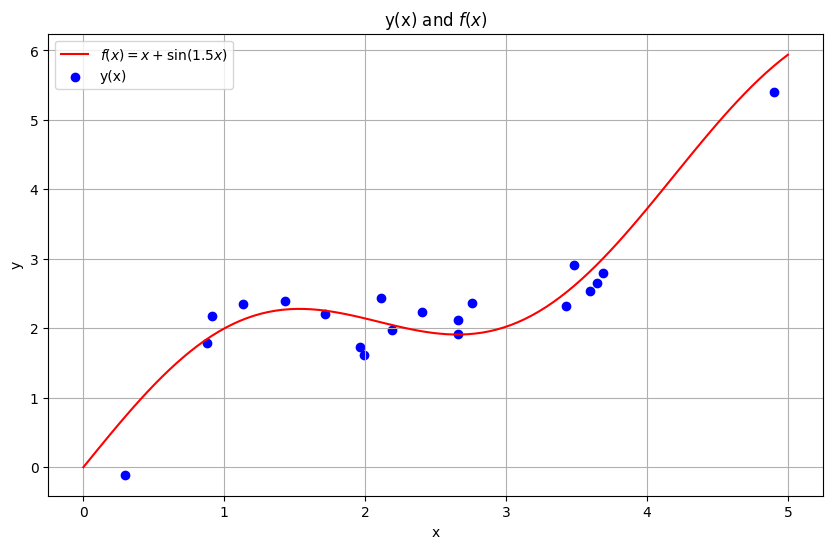

In [82]:
import warnings
warnings.filterwarnings('ignore')

from collections import defaultdict
import numpy as np
from matplotlib import pyplot as plt
from statistics import mean
np.random.seed(123)

ERROR_COLOR = 'darkred'
POLYNOMIAL_FIT_COLORS = ['orange', 'royalblue', 'darkgreen', 'pink']
N_OBSERVATIONS = 20
NOISE_STD = 0.3

x = 5 * (np.random.rand(N_OBSERVATIONS))
x_grid = np.linspace(0, 5, 100)

def f(x):
    """Base function"""
    return x + np.sin(1.5 * x)


def sample_fx_data(shape, noise_std=NOISE_STD):
    return f(x) + np.random.randn(*shape) * noise_std


def plot_fx_data(y=None):
    """Plot f(x) and noisy samples"""
    y = y if y is not None else sample_fx_data(x.shape)
    fig, axs = plt.subplots(figsize=(10, 6))
    plt.plot(x_grid, f(x_grid), color='red', label='$f(x) = x + \sin(1.5x)$')
    plt.scatter(x, y, label='y(x)', color='blue', marker='o')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('y(x) and $f(x)$')
    plt.legend()
    plt.grid(True)

y = sample_fx_data(x.shape)
plot_fx_data(y)

**Answer:**

Here is a graphical representation of y(x) as a scatter plot and f(x) as a smooth line.

## 1.2

Text(0.5, 1.0, 'Various Polynomial Functions Fit to Observations')

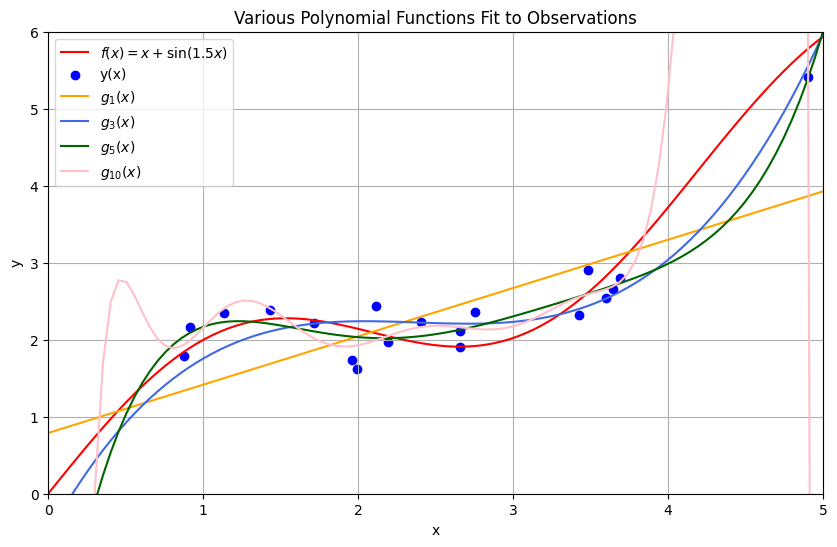

In [83]:
plot_fx_data(y)

polynomial_degrees = [1, 3, 5, 10]
theta = {}
fit = {}
for ii, degree in enumerate(polynomial_degrees):
    # Note: we should get an overconditioned warning for degree 10 because of extreme overfitting
    theta[degree] = np.polyfit(x, y, degree)
    fit[degree] = np.polyval(theta[degree], x_grid)
    plt.plot(x_grid, fit[degree], POLYNOMIAL_FIT_COLORS[ii], label=f'$g_{{{degree}}}(x)$')
plt.legend()
plt.xlim([0, 5])
plt.ylim([0, 6])
plt.title("Various Polynomial Functions Fit to Observations")

**Answer:**

We can immediatelly see that the pink line, $g_{{{10}}}(x)$, is overfitting since it is fitting to well with the noise in order to go through as many points as possible. This kind of model is not going to generalize well on new unseen data. Further, we can also see that the orange line, $g_{{{1}}}(x)$, severly underfits out data since it is a straight line that does not at all follow the pattern of the dataset. This kind of model recognises very little of the pattern that our data set has.


From this we see that the polynomials of very low degrees ($g_{{{1}}}(x)$) are very likely to underfit the data and we can also see the more we increase the degree it model starts to overfit the data ($g_{{{10}}}(x)$). By trying different options and using different statistical test we need to find a perfect balance in our polynomial degree choice.

## 1.3

In [88]:
np.random.seed(123)
n_observations_per_dataset = 50
n_datasets = 100
max_poly_degree = 15  # Maximum model complexity
model_poly_degrees = range(1, max_poly_degree + 1)

NOISE_STD = .3
percent_train = .8
n_train = int(np.ceil(n_observations_per_dataset * percent_train))

# Create training/testing inputs
x = np.linspace(0, 5, n_observations_per_dataset)
x = np.random.permutation(x)
x_train = x[:n_train]
x_test = x[n_train:]

### 1.3.(a)

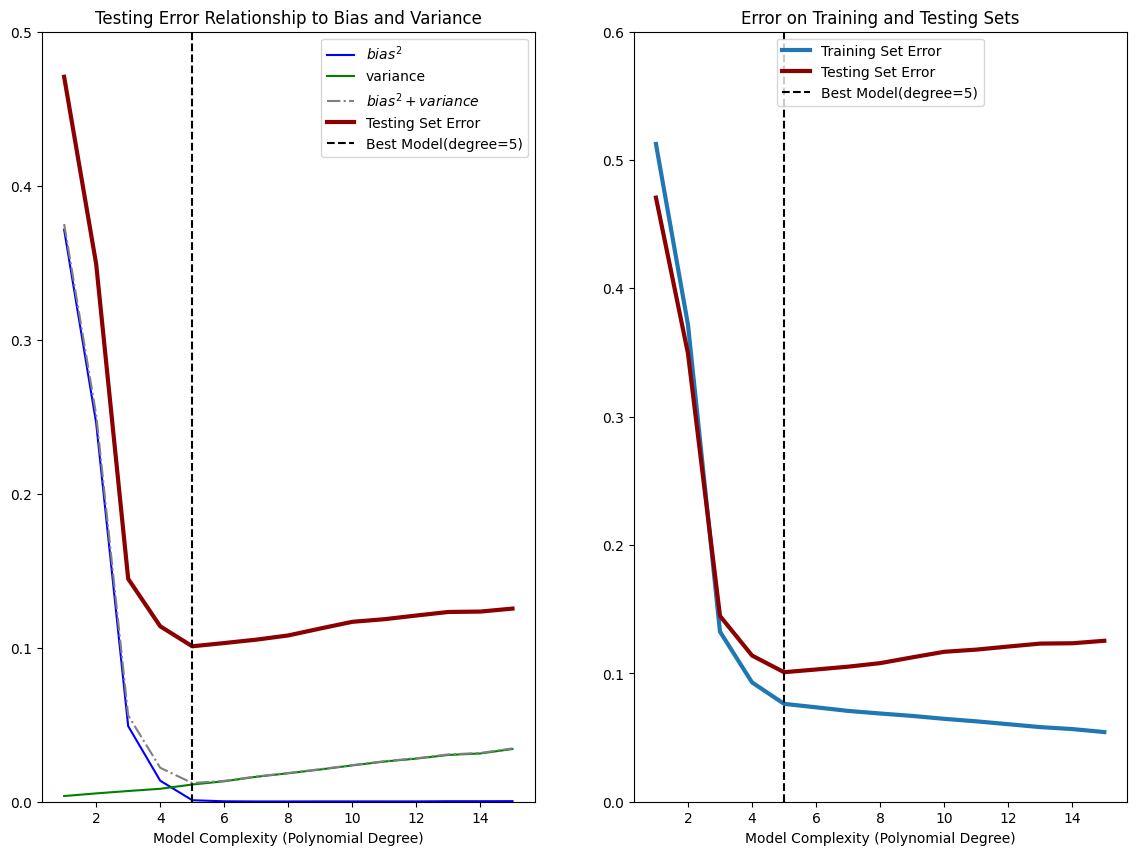

In [96]:
# logging variables
theta_hat = defaultdict(list)

pred_train = defaultdict(list)
pred_test = defaultdict(list)

train_errors = defaultdict(list)
test_errors = defaultdict(list)

def error_function(pred, actual):
    return (pred - actual) ** 2

# Loop over datasets
for dataset in range(n_datasets):

    # Simulate training/testing targets
    y_train = f(x_train) + NOISE_STD * np.random.randn(*x_train.shape)
    y_test = f(x_test) + NOISE_STD * np.random.randn(*x_test.shape)

    # Loop over model complexities
    for degree in model_poly_degrees:
        # Train model
        tmp_theta_hat = np.polyfit(x_train, y_train, degree)

        # Make predictions on train set
        tmp_pred_train = np.polyval(tmp_theta_hat, x_train)
        pred_train[degree].append(tmp_pred_train)

        # Test predictions
        tmp_pred_test = np.polyval(tmp_theta_hat, x_test)
        pred_test[degree].append(tmp_pred_test)

        # Mean Squared Error for train and test sets
        train_errors[degree].append(np.mean(error_function(tmp_pred_train, y_train)))
        test_errors[degree].append(np.mean(error_function(tmp_pred_test, y_test)))


def calculate_estimator_bias_squared(pred_test):
    pred_test = np.array(pred_test)
    average_model_prediction = pred_test.mean(0)  # E[g(x)]

    # (E[g(x)] - f(x))^2, averaged across all trials
    return np.mean((average_model_prediction - f(x_test)) ** 2)


def calculate_estimator_variance(pred_test):
    pred_test = np.array(pred_test)
    average_model_prediction = pred_test.mean(0)  # E[g(x)]

    # (g(x) - E[g(x)])^2, averaged across all trials
    return np.mean((pred_test - average_model_prediction) ** 2)


complexity_train_error = []
complexity_test_error = []
bias_squared = []
variance = []
for degree in model_poly_degrees:
    complexity_train_error.append(np.mean(train_errors[degree]))
    complexity_test_error.append(np.mean(test_errors[degree]))
    bias_squared.append(calculate_estimator_bias_squared(pred_test[degree]))
    variance.append(calculate_estimator_variance(pred_test[degree]))

best_model_degree = model_poly_degrees[np.argmin(complexity_test_error)]


# Visualizations
fig, axs = plt.subplots(1, 2, figsize=(14, 10))

## Plot Bias^2 + variance
plt.sca(axs[0])
plt.plot(model_poly_degrees, bias_squared, color='blue', label='$bias^2$')
plt.plot(model_poly_degrees, variance, color='green', label='variance')
plt.plot(model_poly_degrees, np.array(bias_squared) + np.array(variance),  linestyle='-.', color='gray', label='$bias^2 + variance$')
plt.plot(model_poly_degrees, complexity_test_error, label='Testing Set Error', linewidth=3, color=ERROR_COLOR)
plt.axvline(best_model_degree, linestyle='--', color='black', label=f'Best Model(degree={best_model_degree})')
#plt.plot(model_poly_degrees, np.array(complexity_test_error) - (np.array(bias_squared) + np.array(variance)), color='red', label='Testing Error - ($bias^2 + variance$)')
#plt.axhline(NOISE_STD **2, color='tomato', linestyle='--', label=f'$\sigma_2$ = {round(NOISE_STD**2, 3)}')

plt.xlabel('Model Complexity (Polynomial Degree)')
plt.ylim([0, .5]);
plt.legend()
plt.title('Testing Error Relationship to Bias and Variance')

## Plot Train / Test Set Error
plt.sca(axs[1])
plt.plot(model_poly_degrees, complexity_train_error, label='Training Set Error', linewidth=3)
plt.plot(model_poly_degrees, complexity_test_error, label='Testing Set Error', linewidth=3, color=ERROR_COLOR)
plt.axvline(best_model_degree, linestyle='--', color='black', label=f'Best Model(degree={best_model_degree})')
plt.ylim([0, .6]);
plt.xlabel('Model Complexity (Polynomial Degree)')
plt.title('Error on Training and Testing Sets')
plt.legend(loc='upper center')

**Answer:**

As we noticed in part 2 of the problem, increasing the model complexity makes the model perform better for our data. However, once this complexity gets too large the model is overfitting the data which means it will not generalize well on new previously unseen data. We can also see that from the graphs above where we can notice that increasing the model complexity decreases the model error, but only until it gets to the lowest value when the complexity is at 5 after which it starts increasing once again, most likely due to overfitting the model.

### 1.3.(b)

In [98]:
best_model_degree = model_poly_degrees[np.argmin(complexity_test_error)]

print('Best model degree:', best_model_degree)
print('Bias squared for this model:', round(bias_squared[5],4))
print('Bias for this model:', round(np.sqrt(bias_squared[5]),4))
print('Variance for this model:', round(variance[5],4))

Best model degree: 5
Bias squared for this model: 0.0003
Bias for this model: 0.0167
Variance for this model: 0.0133


**Answer:**

As we could see on the previous graph, the model with minimized error is the model with complexity equal to 5. This model minimizes the error and decreasing or increasing the complexity would increase the error once again. This model has Bias Squared of 0.0003 and Variance of 0.0133 so we can say it performs well.